# Delays on the NYC MTA Subway (2020-2022)

The NYC Metropolitan Area contains approx. 20 million people, a lot of who rely on public transit with this area of the country having the best public transit in both service and scope. Public transit is incredibly important to get around the NYC area but with constant delays and issues arising in the subway, this analysation will help bring further into light some of the numbers with delays with the MTA subway from 2020 and after the pandemic (2021, 2022)

A full map of the New York City Metropolitan Transit Authority Subway that runs through all 5 boroughs. In this data analysis that I present, I will only be dealing with service that runs through all boroughs except Staten Island (due to it's seperate nature from the main lines that carries the main bulk of traffic in the system) and the airtrain that runs to JFK and LGA.

![NYC MTA Subway Lines](images/Subway_Map_NYC.png)

Checking for Null/NaN values

In [1]:
import numpy as np
import pandas as pd

train_delays_df = pd.read_csv('data/MTA_Subway_Trains_Delayed.csv')

#check for NaN/Null values
print(train_delays_df.isnull().sum())
train_delays_df['subcategory'].fillna('Operating Conditions', inplace=True)
print(train_delays_df.isnull().sum())


month                    0
subdivison               0
line                     0
day_type                 0
reporting_category       0
subcategory           1680
delays                   0
dtype: int64
month                 0
subdivison            0
line                  0
day_type              0
reporting_category    0
subcategory           0
delays                0
dtype: int64


Please note that there is no "W" line in the dataframe and the "line" column. This is due to the inconsistencies of operation on the line with constant suspension of the line systemwide. The J and the Z line are placed together as the JZ line since they run along the same route with the J line running the local route and the Z line running the express.

Seperating Line specific and Total Systemwide delays

In [2]:
train_delays_df['month'] = pd.to_datetime(train_delays_df['month']) # converts obj time to datetime data type!
line_delays_df = train_delays_df[train_delays_df.subdivison != 'Systemwide'] # only want delay's specific to each line
line_delays_df

,month,subdivison,line,day_type,reporting_category,subcategory,delays
0,2023-06-01,A DIVISION,1,1,Crew Availability,Crew Availability,80
1,2023-06-01,A DIVISION,1,1,External Factors,External Debris on Roadbed,62
2,2023-06-01,A DIVISION,1,1,Infrastructure & Equipment,Braking,16
3,2023-06-01,A DIVISION,1,1,Infrastructure & Equipment,Door-Related,43
4,2023-06-01,A DIVISION,1,1,Infrastructure & Equipment,"Fire, Smoke, Debris",34
...,...,...,...,...,...,...,...
28325,2020-01-01,B DIVISION,S Rock,2,Infrastructure & Equipment,Service Delivery,3
28326,2020-01-01,B DIVISION,S Rock,2,Operating Conditions,Operating Conditions,1
28327,2020-01-01,B DIVISION,S Rock,2,Planned ROW Work,Subways Maintenance,2
28328,2020-01-01,B DIVISION,S Rock,2,Police & Medical,"Public Conduct, Crime, Police Response",15


Defining seperate dataframes to contain all the delays per line per year

In [3]:
def line_delays_by_year(year:int):
    '''Define the cumulative sum of all delays per line per year'''
    
    if year < 2020 or year > 2022:
        return ValueError("Invalid year. Year must be between 2020 and 2022.")
    
    str_year = str(year)
    total_delays_2022_df = line_delays_df[line_delays_df.month.dt.strftime('%Y') == str_year]
    total_delays_2022_df = total_delays_2022_df.reset_index(drop=True)

    lines = total_delays_2022_df['line'].unique() # all subway lines being counted
    lines = lines.astype('U')
    lines = np.char.strip(lines)
    lines = np.char.replace(lines, ' ', '')
    lines = ['line_' + line + '_delays' for line in lines] # make an array of variables to store the # of delays on each line, use them to compare with each, and year over year.

    delays_df = pd.DataFrame({
        'Line': lines,
        'Year': year,
        'Total Delays': [total_delays_2022_df[total_delays_2022_df.line == line]['delays'].sum() for line in total_delays_2022_df['line'].unique()]
    })

    delays_df['Line'] = total_delays_2022_df['line'].unique()

    return delays_df

all_lines_delayed_2020, all_lines_delayed_2021, all_lines_delayed_2022 = (line_delays_by_year(i) for i in range(2020,2023))

Defining seperate variables to contain the values for all the delays in total per year

In [4]:
def total_systemwide_delays_by_year(year:int):
    '''Define the cumulative sum of all delays per year (Systemwide Delays)'''

    if year < 2020 or year > 2022:
        return ValueError("Invalid year. Year must be between 2020 and 2022.")

    str_year = str(year)
    systemwide_delays_df = train_delays_df[train_delays_df.month.dt.strftime('%Y') == str_year]
    systemwide_delays_df = systemwide_delays_df[systemwide_delays_df.subdivison == 'Systemwide']
    systemwide_delays_df.reset_index(drop=True)

    sum_systemwide_total_delays = systemwide_delays_df.delays.sum()
    return sum_systemwide_total_delays

total_systemwide_delays_2020, total_systemwide_delays_2021, total_systemwide_delays_2022 = (total_systemwide_delays_by_year(i) for i in range (2020,2023))

### General Overview of the MTA lines and Their Delays Year Over Year

There is a general increase in delays across most lines as we compare each line to itself to the next year

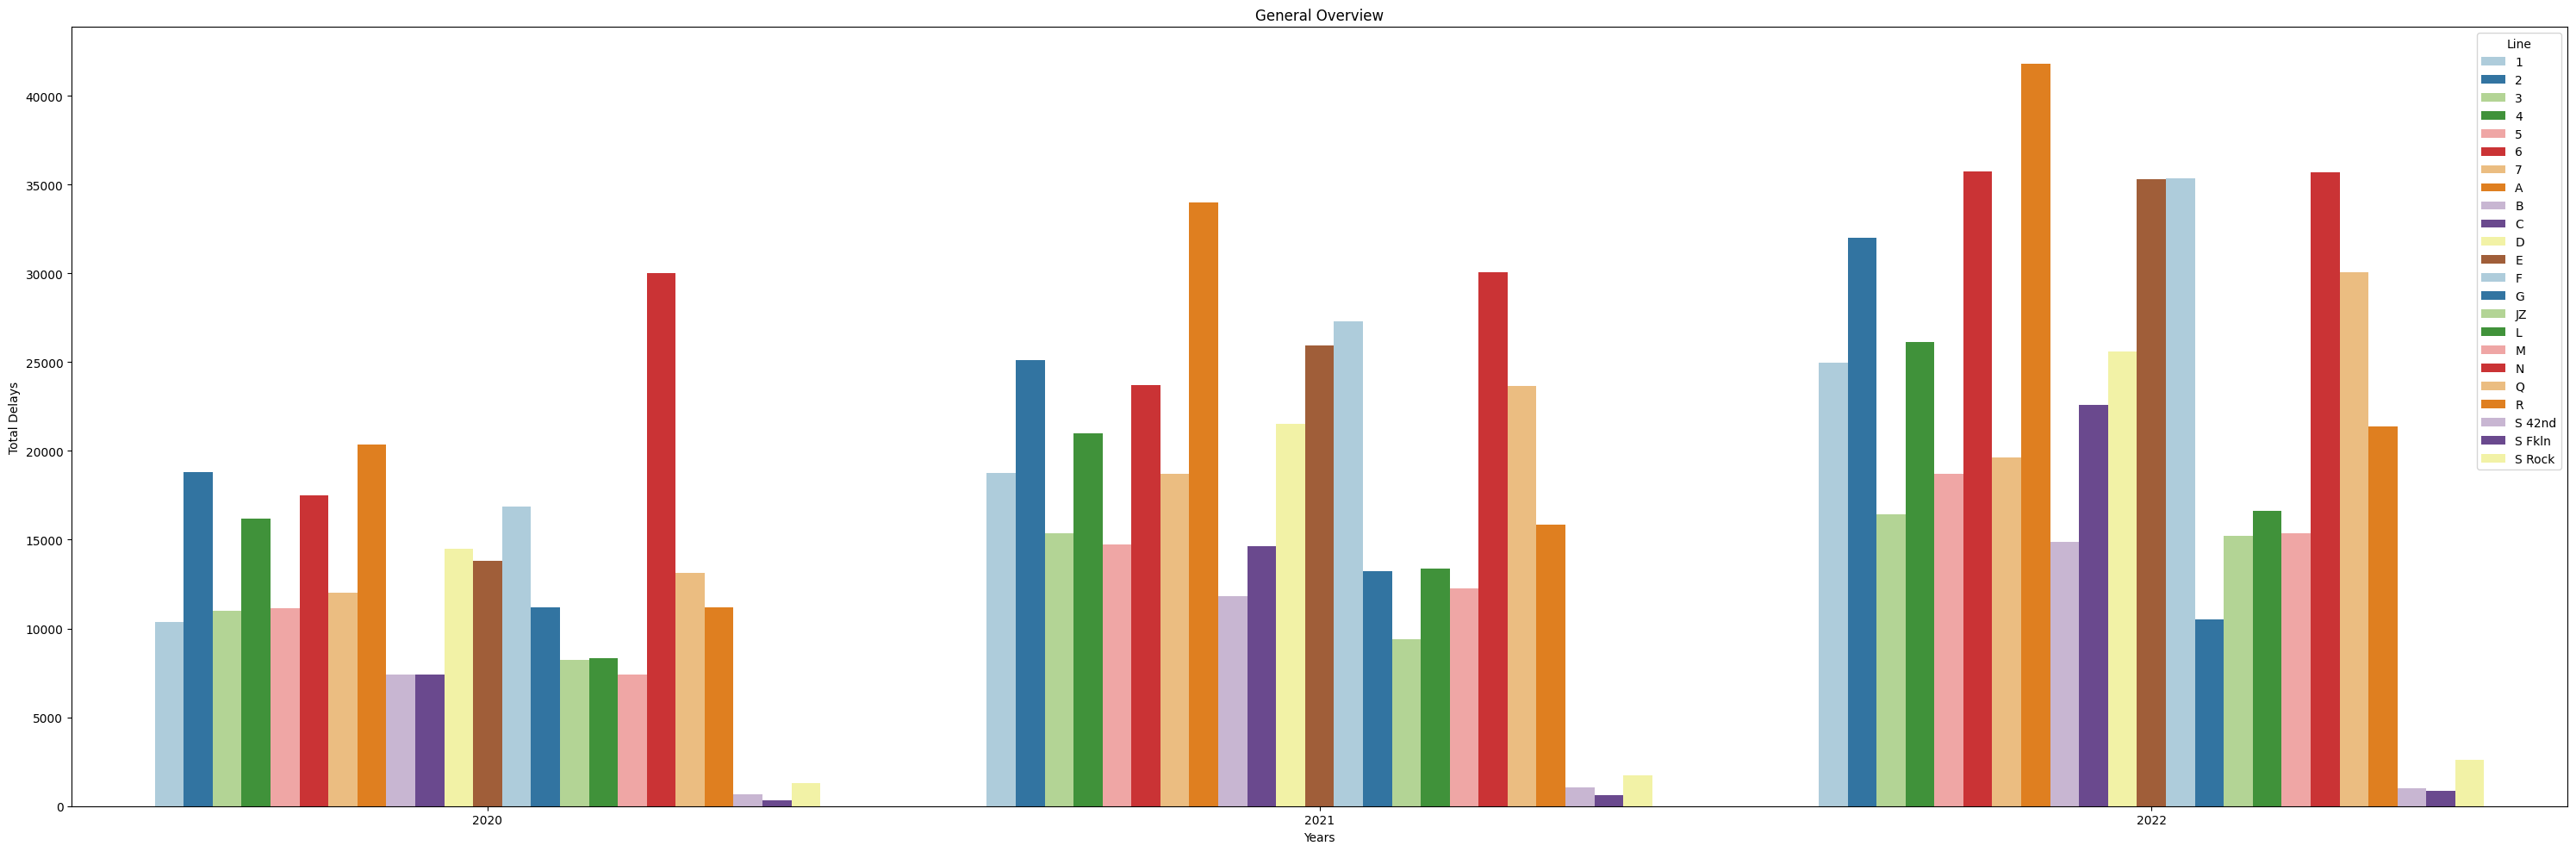

In [5]:
'''The barplot below side by side shows the number of delays per subway line year after year from 2020 to 2022'''

import seaborn as sns
import matplotlib.pyplot as plt

# compare all lines and their delays year over year

all_lines = pd.concat([all_lines_delayed_2020, all_lines_delayed_2021, all_lines_delayed_2022])
all_lines.reset_index(inplace=True, drop='index')

# number trains 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30, 10))

sns.barplot(data=all_lines, x='Year', y='Total Delays', hue='Line', palette='Paired')
plt.title("General Overview") # change name
plt.xlabel('Years')
plt.ylabel('Total Delays')

plt.tight_layout()
plt.show()

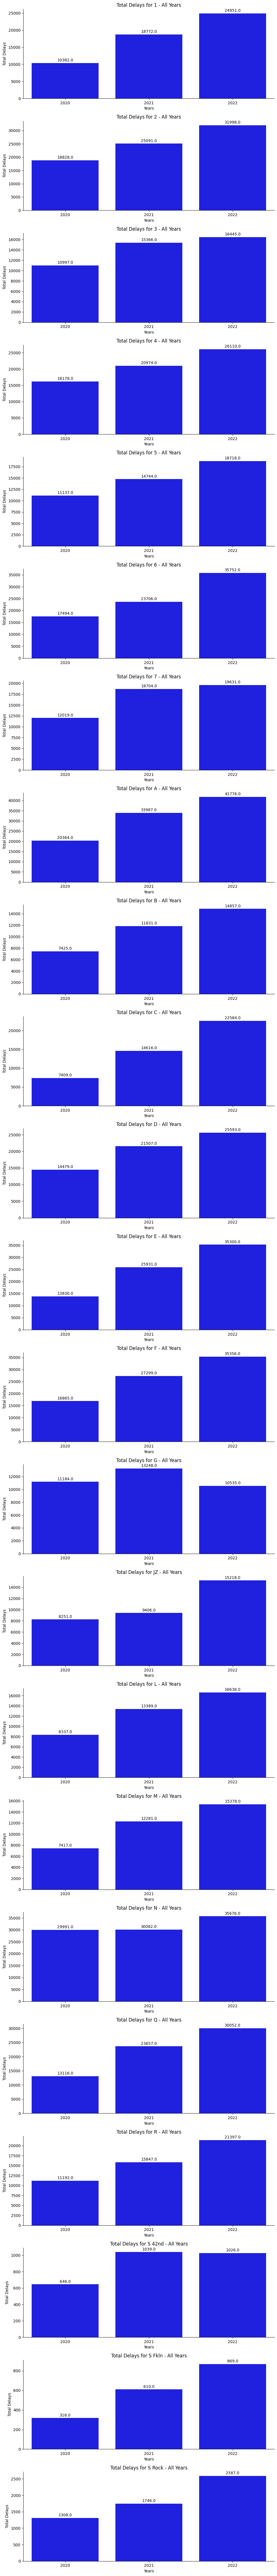

In [6]:
'''Information displayed shows the number of delays per subway line year after year individually compared to itself'''

# Get unique subway lines
subway_lines = all_lines['Line'].unique()

# Create subplots based on the number of unique subway lines
fig, axes = plt.subplots(nrows=len(subway_lines), ncols=1, figsize=(10, 4 * len(subway_lines)))

# Loop through each subway line and create a bar plot for each
for i, subway_line in enumerate(subway_lines):
    data_for_line = all_lines[all_lines['Line'] == subway_line]
    sns.barplot(data=data_for_line, x='Year', y='Total Delays', ax=axes[i], color='blue')  # You can choose any color you prefer
    axes[i].set_xlabel('Years')
    axes[i].set_ylabel('Total Delays')
    axes[i].set_title(f'Total Delays for {subway_line} - All Years')
    axes[i].tick_params(axis='x')

    # Add delay values on top of each bar
    for bar in axes[i].containers[0]:
        height = bar.get_height()
        axes[i].annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 2), textcoords='offset points',ha='center', va='bottom')

sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

Aggregation to find out which lines have the least and most delays from 2020-2022

In [7]:
'''Displayed below in a dataframe is the subway & shuttle line that had the least and most delays from 2020 to 2022'''

total_delays = all_lines_delayed_2020['Total Delays'] + all_lines_delayed_2021['Total Delays'] + all_lines_delayed_2022['Total Delays']
p = pd.DataFrame({
    'Line': all_lines_delayed_2020['Line'],
    'Overall Line Delays (2020-2022)': total_delays
})

# make another df for shuttles to better differentiate among the number of delays
shuttle_df = p
shuttle_df = shuttle_df[total_delays < 10000]
shuttle_df.reset_index(inplace=True, drop='index')

p = p[total_delays > 10000]

min_mta_line_delay = p.iloc[p['Overall Line Delays (2020-2022)'].idxmin()]
max_mta_line_delay = p.iloc[p['Overall Line Delays (2020-2022)'].idxmax()]
min_mta_shuttle_delay = shuttle_df.iloc[shuttle_df['Overall Line Delays (2020-2022)'].idxmin()]
max_mta_shuttle_delay = shuttle_df.iloc[shuttle_df['Overall Line Delays (2020-2022)'].idxmax()]

min_max_delays = pd.DataFrame({
    'Lines': [min_mta_line_delay.Line, max_mta_line_delay.Line, min_mta_shuttle_delay.Line, max_mta_shuttle_delay.Line],
    'Type': ['Main (Min)', 'Main (Max)', 'Shuttle (Min)', 'Shuttle(Max)'],
    'Delays': [min_mta_line_delay['Overall Line Delays (2020-2022)'], max_mta_line_delay['Overall Line Delays (2020-2022)'], min_mta_shuttle_delay['Overall Line Delays (2020-2022)'], max_mta_shuttle_delay['Overall Line Delays (2020-2022)']]
})

min_max_delays

,Lines,Type,Delays
0,JZ,Main (Min),32875
1,A,Main (Max),96127
2,S Fkln,Shuttle (Min),1797
3,S Rock,Shuttle(Max),5641


The A Line has the most delays, the JZ line contains the least.
The Franklin Ave. shuttle has the most delays, the far Rockaway Shuttle has the last.

### Overall Systemwide Delays Year Over Year

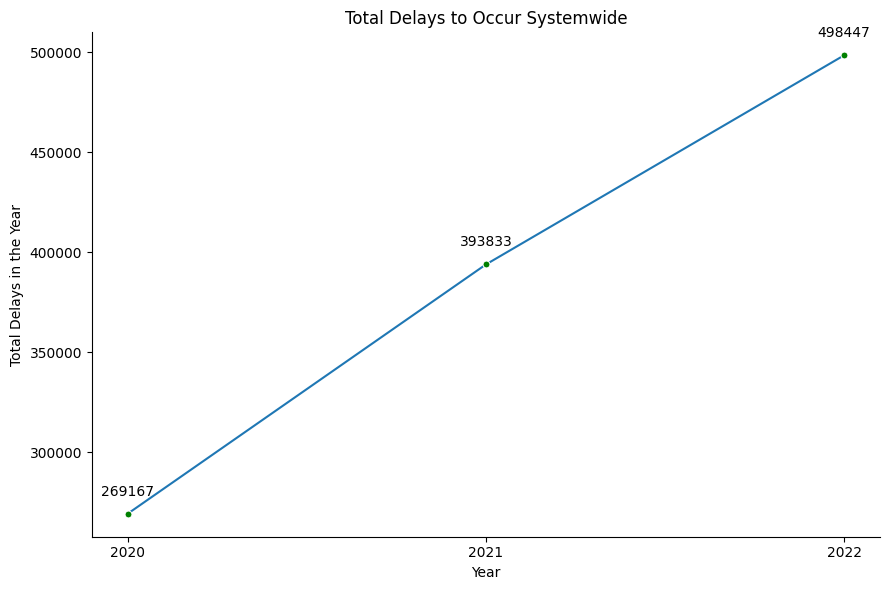

In [8]:
'''Line Plot made to showcase the change in value of overall delays that occur year by year'''

value_difference_year_by_year = pd.DataFrame({
    'Year': ('2020', '2021', '2022'),
    'Total Delays in the Year': (total_systemwide_delays_2020, total_systemwide_delays_2021, total_systemwide_delays_2022)
})

fig, ax = plt.subplots(figsize=(9, 6))
sns.lineplot(data=value_difference_year_by_year, x='Year', y='Total Delays in the Year', marker='.', markersize=10, markerfacecolor='green')

# Loop through the data and add the delay value for each data point
for index, row in value_difference_year_by_year.iterrows():
    ax.annotate(f'{row["Total Delays in the Year"]}', (row['Year'], row['Total Delays in the Year']),
                textcoords="offset points", xytext=(0,13), ha='center')

sns.despine(top=True, right=True)
plt.title('Total Delays to Occur Systemwide')
plt.tight_layout()

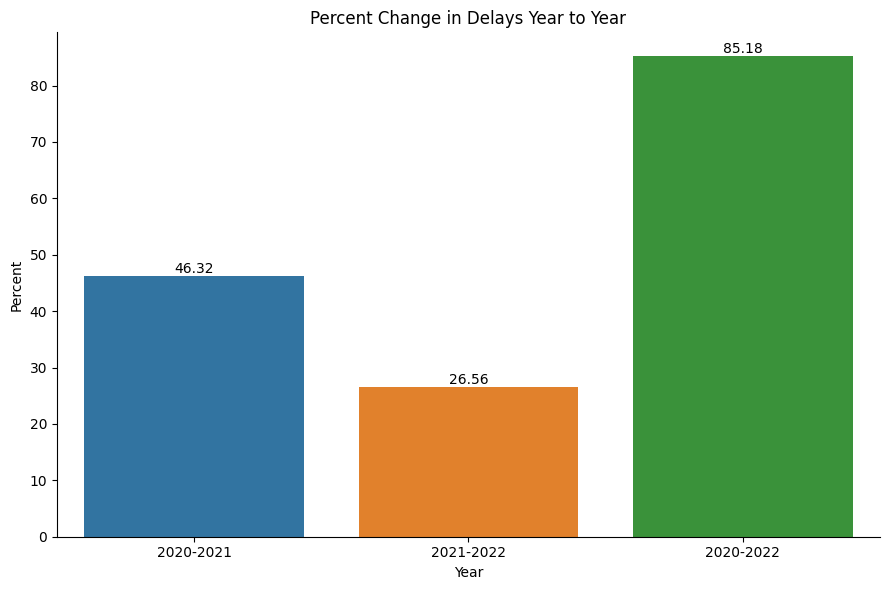

In [9]:
# aggregations | percent changes in delays from values of delays that occured year by year

def percent_change(year_1:int, year_2:int):
    value = (year_2 - year_1)/abs(year_1) * 100
    return round(value, 2)

percent_change_2020_2021 = percent_change(total_systemwide_delays_2020, total_systemwide_delays_2021)
percent_change_2021_2022 = percent_change(total_systemwide_delays_2021, total_systemwide_delays_2022)
total_percent_change_2020_2022 = percent_change(total_systemwide_delays_2020, total_systemwide_delays_2022)

'''Barplot displays the percent change of the number of delays from one year to another'''

percent_change = pd.DataFrame({
    'Year': ('2020-2021', '2021-2022', '2020-2022'),
    'Percent': (percent_change_2020_2021, percent_change_2021_2022, total_percent_change_2020_2022)
})

fig, ax = plt.subplots(figsize=(9, 6))
sns.barplot(data=percent_change, x='Year', y='Percent')
plt.title('Percent Change in Delays Year to Year')
ax.bar_label(ax.containers[0])
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

We can see how there has been a significant increase from the total number of delays that occur from 2020 to 2022 with there being a lower increase in delays from 2021-2022 than from 2020-2021   